This project aims to develop a predictive model for estimating fare amounts for uber rides, using features such as distance traveled, number of passengers, and time of day (rush hour). 

source of dataset: https://www.kaggle.com/datasets/kushsheth/uber-ride-price-prediction/data

# Imports

In [336]:
# Data manipulation and analysis 
import pandas as pd

# Numerical operations
import numpy as np

# Statistical data visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Evaluating regression model with mean squared error
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Performing ordinary least squares regression
from statsmodels.formula.api import ols

# Additional statistical tests
import statsmodels.api as sm


In [337]:
df = pd.read_csv('/Users/craigware/Downloads/uber.csv')
df.head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


# Cleaning

## Removing missing values

In [339]:
# Display rows with any missing values (NaNs).
df[df.isna().any(axis=1)]


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,51:57.0,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [340]:
# Drop rows with any missing values and reset the index.
df0 = df.dropna(axis=0).reset_index()

# Display rows with any missing values (should be none after dropna).
df0[df0.isna().any(axis=1)]


,index,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


## Filtering Coordinates

Ensures latitude and longitude values are within valid global ranges.

Latitude ranges from -90° to +90° (north/south of the Equator), and longitude ranges from -180° to +180° (east/west of the Prime Meridian).

In [341]:
# Ensure coordinates are within valid ranges
df0 = df0[(df0['pickup_longitude'] >= -180) & (df0['pickup_longitude'] <= 180)]
df0 = df0[(df0['dropoff_longitude'] >= -180) & (df0['dropoff_longitude'] <= 180)]
df0 = df0[(df0['pickup_latitude'] >= -90) & (df0['pickup_latitude'] <= 90)]
df0 = df0[(df0['dropoff_latitude'] >= -90) & (df0['dropoff_latitude'] <= 90)]
df1 = df0[[
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count"]].reset_index(drop=True)
df1.shape

(199987, 7)

## Calculating Distance
Uses the geodesic function from geopy.distance to compute the distance in miles between pickup and dropoff coordinates in df1, storing results in a new `distance` column.

In [342]:
from geopy.distance import geodesic

# Function to calculate distance between two coordinates
def calculate_distance(pickup, dropoff):
    return geodesic(pickup, dropoff).miles

# Apply the function to calculate distance
df1['distance'] = df1.apply(lambda row: calculate_distance((row['pickup_latitude'], row['pickup_longitude']),
                                                             (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)

df1.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],axis=1,inplace=True)

In [343]:
# Convert 'pickup_datetime' column to datetime format
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])

# Create 'day' column with the name of the day in lowercase
df1['day'] = df1['pickup_datetime'].dt.day_name().str.lower()

# Create 'month' column with the abbreviated month name in lowercase
df1['month'] = df1['pickup_datetime'].dt.strftime('%b').str.lower()

# Create 'rush_hour' column with the hour of the pickup
df1['rush_hour'] = df1['pickup_datetime'].dt.hour

# Set 'rush_hour' to 0 if the day is Saturday or Sunday
df1.loc[df1['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

# Create 'year' column with the year of the pickup
df1['year'] = df1['pickup_datetime'].dt.year

In [344]:
def rush_hourizer(hour):
    # Check if the hour is within morning rush hour (6-9 AM)
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    # Check if the hour is within evening rush hour (4-7 PM)
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    # If not within rush hour, set value to 0
    else:
        val = 0
    return val

# Apply 'rush_hourizer' to 'rush_hour' column for weekdays
df1.loc[(df1.day != 'saturday') & (df1.day != 'sunday'), 'rush_hour'] = df1.apply(rush_hourizer, axis=1)


The `rush_hourizer` function categorizes rows in the DataFrame as rush hour if they fall within designated morning and evening peak periods, which helps in analyzing peak traffic times effectively.

# EDA

In [345]:
df1.head()

,fare_amount,pickup_datetime,passenger_count,distance,day,month,rush_hour,year
0,7.5,2015-05-07 19:52:06+00:00,1,1.044594,thursday,may,1,2015
1,7.7,2009-07-17 20:04:56+00:00,1,1.525071,friday,jul,0,2009
2,12.9,2009-08-24 21:45:00+00:00,1,3.131464,monday,aug,0,2009
3,5.3,2009-06-26 08:22:21+00:00,3,1.032372,friday,jun,1,2009
4,16.0,2014-08-28 17:47:00+00:00,5,2.786061,thursday,aug,1,2014


In [346]:
df1.describe(include='all')

,fare_amount,pickup_datetime,passenger_count,distance,day,month,rush_hour,year
count,199987.000000,199987,199987.000000,199987.000000,199987,199987,199987.000000,199987.000000
unique,NaN,NaN,NaN,NaN,7,12,NaN,NaN
top,NaN,NaN,NaN,NaN,friday,may,NaN,NaN
freq,NaN,NaN,NaN,NaN,30878,18857,NaN,NaN
mean,11.359849,2012-03-22 15:14:09.313735424+00:00,1.684544,12.777544,NaN,NaN,0.283243,2011.742463
min,-52.000000,2009-01-01 01:15:22+00:00,0.000000,0.000000,NaN,NaN,0.000000,2009.000000
25%,6.000000,2010-08-25 08:14:05+00:00,1.000000,0.755295,NaN,NaN,0.000000,2010.000000
50%,8.500000,2012-03-21 21:04:00+00:00,1.000000,1.318103,NaN,NaN,0.000000,2012.000000
75%,12.500000,2013-10-19 03:31:59+00:00,2.000000,2.407352,NaN,NaN,1.000000,2013.000000
max,499.000000,2015-06-30 23:40:39+00:00,208.000000,5457.871964,NaN,NaN,1.000000,2015.000000


## Outlier Detection

<Axes: xlabel='passenger_count'>

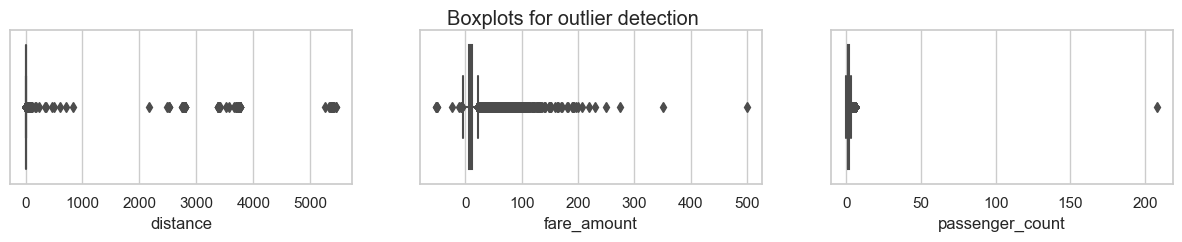

In [347]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df1['distance'])
sns.boxplot(ax=axes[1], x=df1['fare_amount'])
sns.boxplot(ax=axes[2], x=df1['passenger_count'])


There are outliers in `distance`, `fare_amount`, and `passenger_count`. The box plot reveals that distance has outliers ranging from less than 1000 miles to as high as 5000 miles. Notably, there are outlier pockets between 2000 and 4000 miles.

`fare_amount` exhibits outliers both above and below the interquartile range (IQR). Having `fare_amount` values less than or equal to 0 may present challenges for the project's objectives.

Additionally, `passenger_count` values exceeding 200 are unrealistic for Uber rides, and having zero passengers is also not plausible.

### 0 values in `fare_amount`

In [348]:
# Count the number of rows where fare_amount is exactly 0 and below 0
num_fare_amount_zero = df1[df1['fare_amount'] == 0].shape[0]
num_fare_amount_below_zero = df1[df1['fare_amount'] < 0].shape[0]

# Print the counts
print(f"Number of rows with fare_amount equal to 0: {num_fare_amount_zero}")
print(f"Number of rows with fare_amount below 0: {num_fare_amount_below_zero}")

Number of rows with fare_amount equal to 0: 5
Number of rows with fare_amount below 0: 17


Negative fare amounts are unrealistic in uber fare data as they represent payments. By changing any `fare_amount` values below 0 to 0, I will ensure that the data remains consistent, valid, and suitable for analysis and modeling purposes related to uber fare prediction or analysis.

In [349]:
df1 = df1[df1['fare_amount'] > 0]
df1['fare_amount'].min()

0.01

### Irregular values in `passenger_count`

In [350]:
df1.passenger_count.value_counts()

passenger_count
1      138405
2       29423
5       14004
3        8878
4        4275
6        4271
0         708
208         1
Name: count, dtype: int64

By removing entries with unrealistic passenger counts, such as 0 passengers and 208 passengers, I can ensure the dataset's accuracy and improve the robustness of any analyses or models built upon it.

In [351]:
# Remove rows where passenger_count is 0 or 208
df1 = df1[~(df1['passenger_count'] == 0)]
df1 = df1[~(df1['passenger_count'] == 208)]

# Display the count of each passenger_count value after cleaning
df1.passenger_count.value_counts()


passenger_count
1    138405
2     29423
5     14004
3      8878
4      4275
6      4271
Name: count, dtype: int64

### Distance Outliers

`distance` has some extreme values. For simplicity for this project, I will remove otliers from the `distance` column. 

#### Checking 0 values in `distance`

In [352]:
# Round the values in the distance column to 2 decimal places
df1['distance'] = df1['distance'].round(2)

# Count the number of rows where distance is exactly 0
df1[df1['distance'] == 0].shape[0]

6051

Distance directly influences fare calculation in ride-hailing services like Uber. A distance of 0 implies no movement between pickup and dropoff points, which contradicts the purpose of fare calculation based on distance traveled. These could have been other transactions that did not derive from Uber's regular services, but for the purposes of this project, I will be excluding zero values from the `distance` column.

In [353]:
# Remove rows where the distance is 0
df1 = df1[df1['distance'] != 0]

# Check the number of rows where the distance is still 0 (should be 0 if correctly filtered)
remaining_zero_distance_count = df1[df1['distance'] == 0].shape[0]

# Print the count of rows with distance 0 (should be 0)
print(f"Number of rows with distance equal to 0 after filtering: {remaining_zero_distance_count}")

Number of rows with distance equal to 0 after filtering: 0


### Removing `distance` outliers

In [354]:
# Calculate quartiles and interquartile range (IQR) for the 'distance' column
q3 = df1['distance'].quantile(0.75)
q1 = df1['distance'].quantile(0.25)
iqr = q3 - q1

# Calculate lower and upper bounds to identify outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Identify outliers in the 'distance' column
distance_outliers = (df1['distance'] < lower) | (df1['distance'] > upper)


In [355]:
# Count the number of outliers identified in the 'distance' column
df1[distance_outliers].shape[0]


16239

In [356]:
# Remove rows identified as outliers in the 'distance' column
df1 = df1[~distance_outliers]


`fare_amount` also has extreme values. For the simplicity of this project, I will narrow down the data set to fare amounts 100 or less

In [357]:
# Count the number of rows where 'fare_amount' is greater than 100
df1[df1['fare_amount'] > 100].shape[0]


12

In [358]:
# Filter rows where 'fare_amount' is less than or equal to 100
df1 = df1[df1['fare_amount'] <= 100]


The Pearson correlation coefficient is: 0.7399347068708204


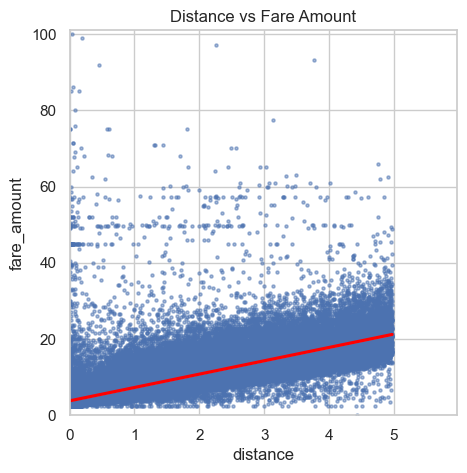

In [359]:
# Set the style and size of the plot
sns.set_theme(style='whitegrid')
plt.figure(figsize=(5, 5))

# Create a scatter plot with a line of best fit
sns.regplot(x=df1['distance'], y=df1['fare_amount'],
            scatter_kws={'alpha': 0.5, 's': 5},
            line_kws={'color': 'red'})
plt.ylim(0, df1['fare_amount'].max() + 1)
plt.xlim(0, df1['distance'].max() + 1)
plt.title('Distance vs Fare Amount')

# Calculate and print the Pearson correlation coefficient
correlation = df1['fare_amount'].corr(df1['distance'])
print(f"The Pearson correlation coefficient is: {correlation}")

The value of 0.74 for the R coeffeicnet is relatively close to 1, which suggests a strong correlation. This means that as as `distance` increases, the `fare_amount` tends to also increase in a fairly predictable manner.

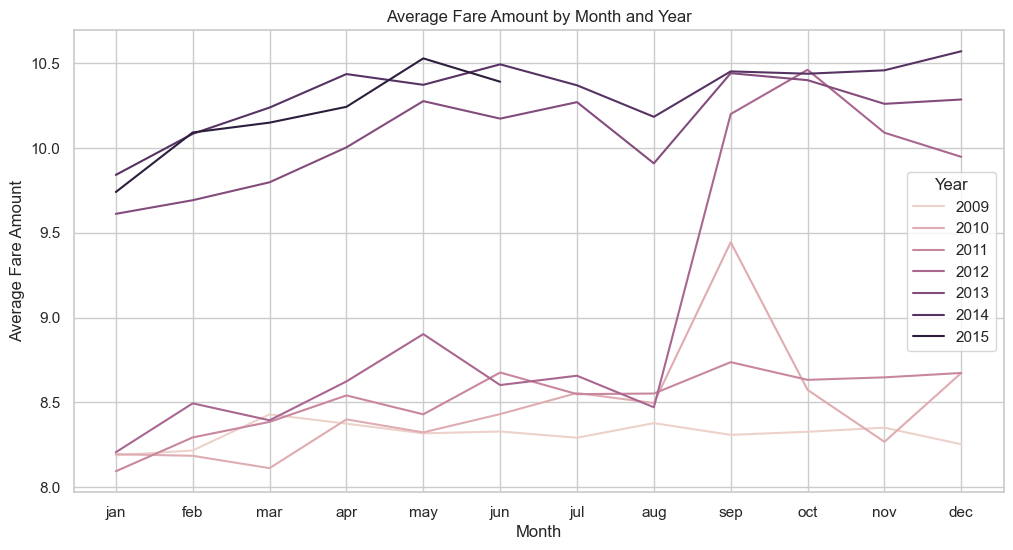

In [360]:
# Define the order of months for categorical sorting
months_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Convert 'month' column to categorical with specified order
df1['month'] = pd.Categorical(df1['month'], categories=months_order, ordered=True)

# Create a line plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='fare_amount', hue='year', data=df1, errorbar=None)  # Removed error bars (ci=None)
plt.title('Average Fare Amount by Month and Year')
plt.xlabel('Month')
plt.ylabel('Average Fare Amount')
plt.legend(title='Year')
plt.show()

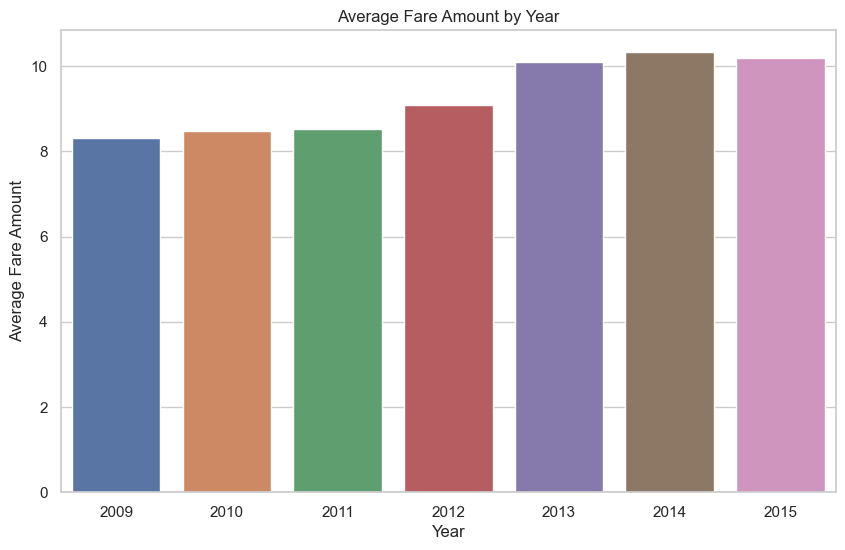

In [361]:
# Bar plot for average fare amount by year
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='fare_amount', data=df1, errorbar=None)
plt.title('Average Fare Amount by Year')
plt.xlabel('Year')
plt.ylabel('Average Fare Amount')
plt.show()


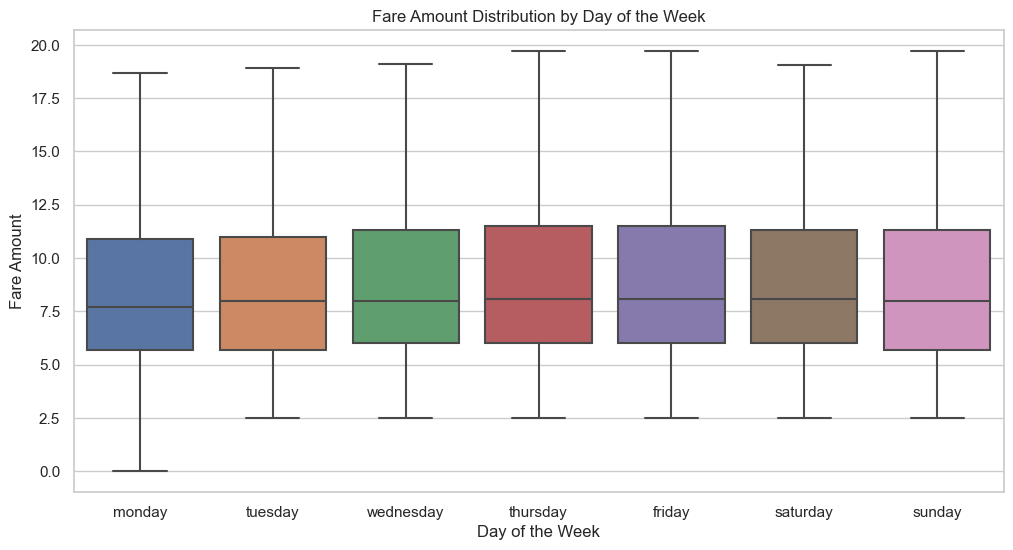

In [362]:
# Define the order of days for categorical sorting
days_order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# Convert 'day' column to categorical with specified order
df1['day'] = pd.Categorical(df1['day'], categories=days_order, ordered=True)

# Create a box plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='day', y='fare_amount', data=df1, showfliers=False)  # Removed outliers from the box plot
plt.title('Fare Amount Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fare Amount')
plt.show()

Text(0, 0.5, 'Fare Amount')

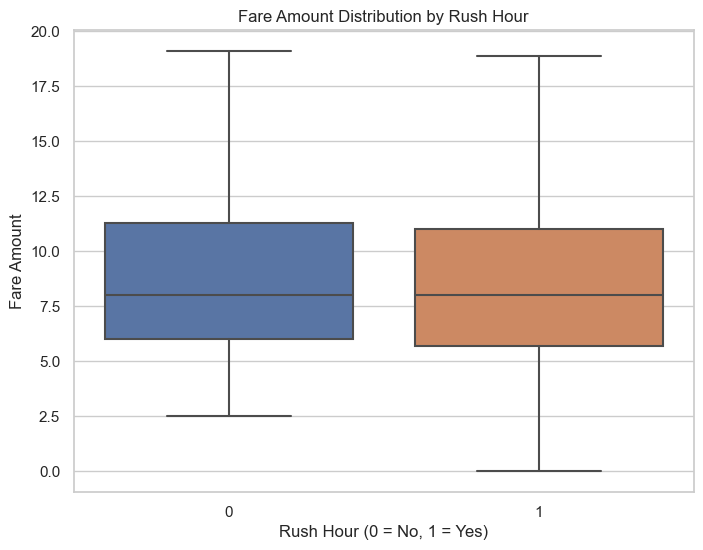

In [363]:
# Box plot for fare amount by rush hour
plt.figure(figsize=(8, 6))
sns.boxplot(x='rush_hour', y='fare_amount', data=df1, showfliers=False)
plt.title('Fare Amount Distribution by Rush Hour')
plt.xlabel('Rush Hour (0 = No, 1 = Yes)')
plt.ylabel('Fare Amount')

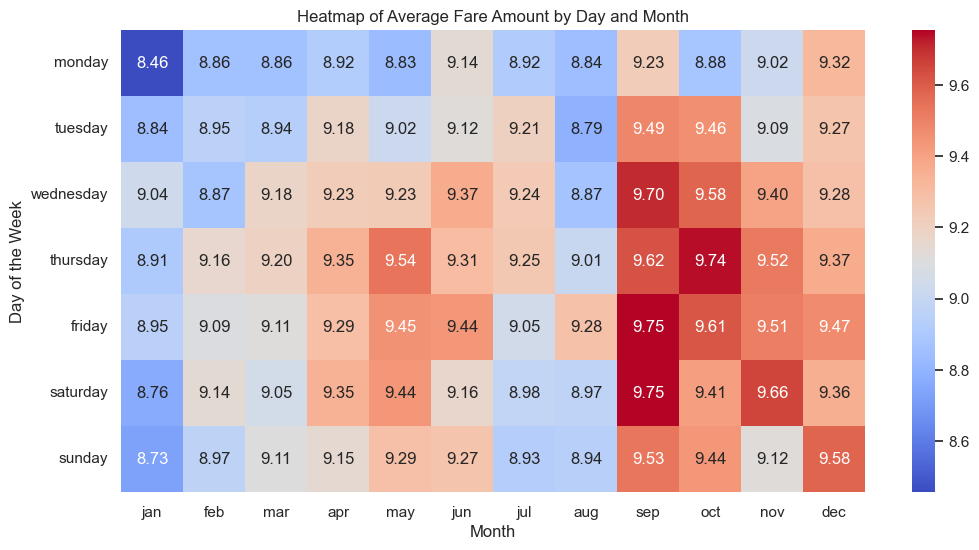

In [364]:
# Pivot the data for heatmap
heatmap_data = df1.pivot_table(values='fare_amount', index='day', columns='month', aggfunc='mean')

# Create a heatmap using seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm')

# Add title and labels to the plot
plt.title('Heatmap of Average Fare Amount by Day and Month')
plt.xlabel('Month')
plt.ylabel('Day of the Week')

# Display the plot
plt.show()

In [365]:
def get_season(date):
    """
    Determine the season for a given date.
    """
    if (date.month == 12 and date.day >= 21) or (date.month in [1, 2]) or (date.month == 3 and date.day <= 20):
        return 'winter'
    elif (date.month == 3 and date.day >= 21) or (date.month in [4, 5]) or (date.month == 6 and date.day <= 20):
        return 'spring'
    elif (date.month == 6 and date.day >= 21) or (date.month in [7, 8]) or (date.month == 9 and date.day <= 20):
        return 'summer'
    else:
        return 'fall'

## Ensure the 'pickup_datetime' column is in datetime format
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])

# Apply the function to create the 'season' column
df1['season'] = df1['pickup_datetime'].apply(get_season)

# Display the first few rows of the DataFrame to verify the 'season' column
df1.head()

,fare_amount,pickup_datetime,passenger_count,distance,day,month,rush_hour,year,season
0,7.5,2015-05-07 19:52:06+00:00,1,1.04,thursday,may,1,2015,spring
1,7.7,2009-07-17 20:04:56+00:00,1,1.53,friday,jul,0,2009,summer
2,12.9,2009-08-24 21:45:00+00:00,1,3.13,monday,aug,0,2009,summer
3,5.3,2009-06-26 08:22:21+00:00,3,1.03,friday,jun,1,2009,summer
4,16.0,2014-08-28 17:47:00+00:00,5,2.79,thursday,aug,1,2014,summer


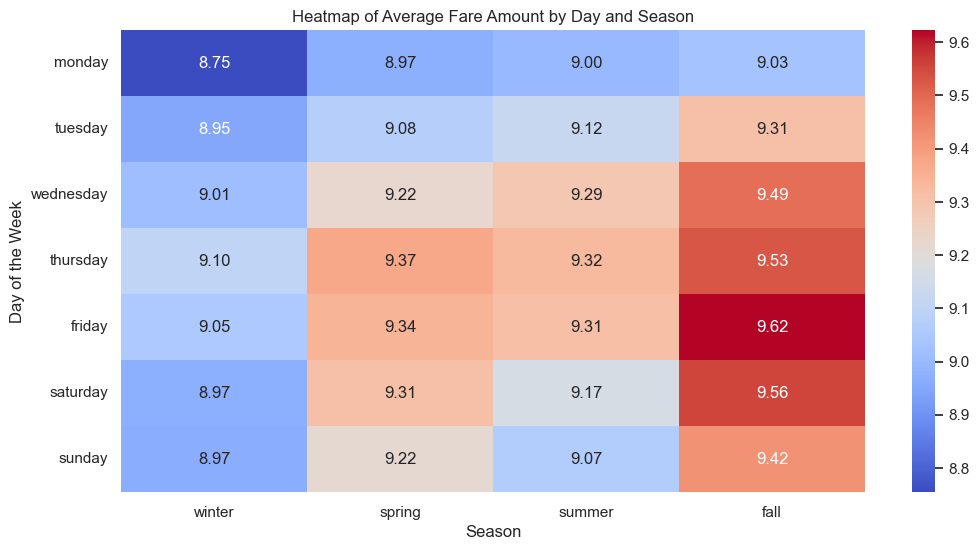

In [366]:
# Pivot the data for heatmap
heatmap_data = df1.pivot_table(values='fare_amount', index='day', columns='season', aggfunc='mean')

# Define the order of seasons for sorting
season_order = ['winter', 'spring', 'summer', 'fall']
heatmap_data = heatmap_data.reindex(columns=season_order)  # Reorder columns based on season_order

# Create a heatmap using seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm')

# Add title and labels to the plot
plt.title('Heatmap of Average Fare Amount by Day and Season')
plt.xlabel('Season')
plt.ylabel('Day of the Week')

# Display the plot
plt.show()

# Model Construction

In [367]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176954 entries, 0 to 199986
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   fare_amount      176954 non-null  float64            
 1   pickup_datetime  176954 non-null  datetime64[ns, UTC]
 2   passenger_count  176954 non-null  int64              
 3   distance         176954 non-null  float64            
 4   day              176954 non-null  category           
 5   month            176954 non-null  category           
 6   rush_hour        176954 non-null  int64              
 7   year             176954 non-null  int32              
 8   season           176954 non-null  object             
dtypes: category(2), datetime64[ns, UTC](1), float64(2), int32(1), int64(2), object(1)
memory usage: 10.5+ MB


In [368]:
# Drop specified columns from df1 and assign to df2
df2 = df1.drop(['pickup_datetime', 'month', 'day', 'year', 'season'], axis=1)
df2.head()

,fare_amount,passenger_count,distance,rush_hour
0,7.5,1,1.04,1
1,7.7,1,1.53,0
2,12.9,1,3.13,0
3,5.3,3,1.03,1
4,16.0,5,2.79,1


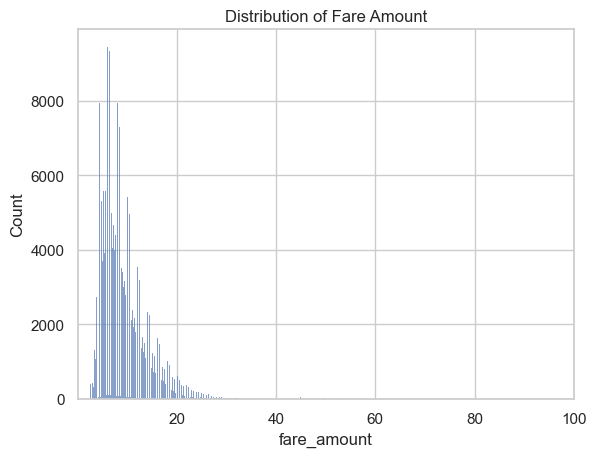

In [369]:
# Create a histogram plot of fare_amount from df2
sns.histplot(df2['fare_amount'])
plt.title('Distribution of Fare Amount')
plt.xlim((df2['fare_amount'].min(),df2['fare_amount'].max()))
plt.show()

I noticed that the distribution is skewed to the right for `fare_amount`. To address this skewness and make the data more suitable for analysis, I decided to log-transform the `fare_amount` values. This transformation helps to normalize the data distribution, making patterns and relationships easier to interpret and analyze.

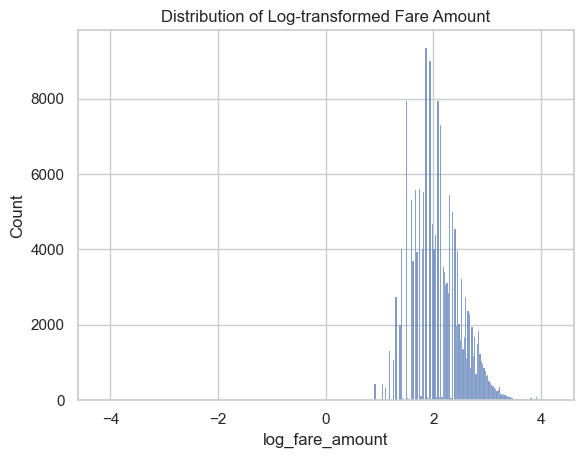

In [370]:
# Log-transform 'fare_amount' into 'log_fare_amount' in df2
df2['log_fare_amount'] = np.log(df2['fare_amount'])

# Create a histogram of the log-transformed fare amounts
sns.histplot(df2['log_fare_amount'])
plt.title('Distribution of Log-transformed Fare Amount')
plt.xlim((df2['log_fare_amount'].min(),df2['log_fare_amount'].max()))
plt.show()

In [371]:
# Create feature matrix X without 'fare_amount' and target variable y with log-transformed 'log_fare_amount'
X = df2.drop(['fare_amount', 'log_fare_amount'], axis=1)
y = df2['log_fare_amount']

In [372]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Using the StandardScaler ensures that all the different features in the data are on a similar scale. This is important for the OLS model because it calculates predictions by comparing the size of each feature's effect on the outcome. If some features have larger numerical values than others, they might unfairly influence the model's predictions. Standardizing the data ensures that each feature's impact is considered fairly, improving the accuracy and reliability of the OLS model's predictions.

In [373]:
# Standardize features using StandardScaler
scaler = StandardScaler()

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the parameters from the training set
X_test_scaled = scaler.transform(X_test)

In [374]:
# Create DataFrames from scaled arrays, preserving column names and indices
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [375]:
# Concatenate the scaled features with the target variable
ols_data = pd.concat([X_train_scaled_df, y_train], axis=1)

# Define the OLS formula
ols_formula = "log_fare_amount ~ distance + passenger_count + rush_hour"
# Fit the OLS model
model = ols(formula=ols_formula, data=ols_data).fit()

# Print the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_fare_amount   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 7.137e+04
Date:                Mon, 24 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:51:16   Log-Likelihood:                -18828.
No. Observations:              123867   AIC:                         3.766e+04
Df Residuals:                  123863   BIC:                         3.770e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1040      0.001   2628.713      0.000       2.102       2.106
distance            0.3707      0.001    462.537      0.000       0.369       0.372
passenger_count     0.0059      0.001      7.364      0.000       0.004       0.007
rush_hour           0.0102      0.001     12.782      0.000       0.009       0.012
==============================================================================
Omnibus:                    35639.439   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           645725.094
Skew:                           0.922   Prob(JB):                         0.00
Kurtosis:                      14.032   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**R-squared**: 
This tells us how well the model explains the variation in fare amounts. An R-squared of 0.634 means 63.4% of the fare amount variation can be predicted by the factors we've included.

**Adjusted R-squared**: 
Similar to R-squared, but it considers the number of predictors in the model. It confirms that our model with distance, passenger count, and rush hour explains the fare amounts effectively.

**Intercept**: 
The intercept of 2.1040 represents the estimated fare amount when all other factors (distance, passenger count, rush hour) are zero. In other words, it's the fare amount we expect to see when none of the other factors are influencing the fare calculation.

**Coefficients**:

* Distance: Each unit increase in distance correlates with a fare amount increase of approximately 37 cents.
* Passenger count: Each additional passenger adds about half a cent to the fare amount.
* Rush hour: Being in rush hour adds around 1 cent to the fare amount.

In [376]:
# Predict using the trained model on the scaled test data
y_pred = model.predict(X_test_scaled_df)

# Calculate Mean Squared Error (MSE)
ols_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {ols_mse}')

# Calculate Mean Absolute Error (MAE)
ols_mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {ols_mae}')

Mean Squared Error: 0.07999785845859346
Mean Absolute Error: 0.20735813215561466


**Mean Squared Error (MSE)**:
This measures the average error between our predicted and actual fare amounts. A lower MSE of approximately 0.080 suggests the model's predictions are generally close to the actual fares.

**Mean Absolute Error (MAE)**:
This gives the average magnitude of errors in predicting fare amounts. With an MAE of around 0.207, the model's predictions are, on average, within about 21 cents of the actual fares.


## Model Assumptions

### Check Normality in Residuals 

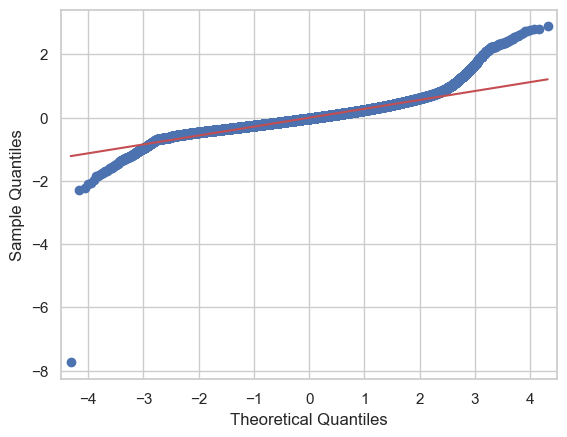

In [377]:
# Calculate residuals
residuals = model.resid

# Create QQ plot
fig = sm.qqplot(residuals, line='s')
plt.show()

Most residuals closely follow the diagonal line, indicating they are approximately normally distributed; however, there are some deviations in the upper and lower tails, suggesting possible outliers or non-normality in those areas. Overall, the QQ plot suggests that the assumption of normally distributed residuals for my regression model is reasonably met, which supports the reliability of my predictions.

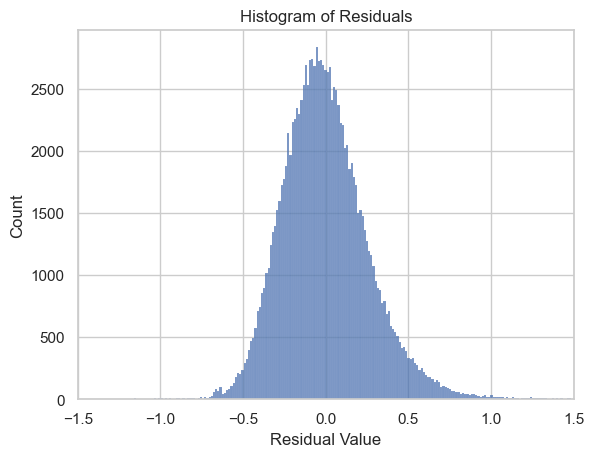

In [378]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.xlim((-1.5,1.5))
plt.show()

### Check for Heteroscedasticity

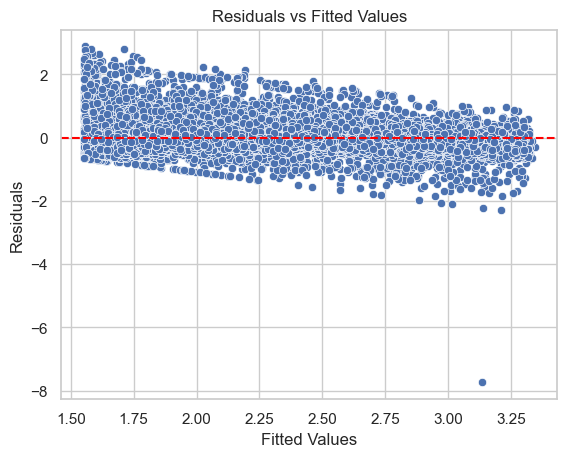

In [379]:
fitted_values = model.fittedvalues

fig, ax = plt.subplots()
sns.scatterplot(x=fitted_values, y=residuals, ax=ax)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Fitted Values")
plt.show()

On average, the model accurately predicts outcomes without too much systematic bias and appears to achieve homoscedasticity.